In [12]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from numba import jit
import time
import gc

In [2]:
MAX_ROUNDS = 400
OPTIMIZE_ROUNDS = False
LEARNING_RATE = 0.07
EARLY_STOPPING_ROUNDS = 50 

In [14]:
# Compute gini
# from CPMP's kernel https://www.kaggle.com/cpmpml/extremely-fast-gini-computation
# @jit
def eval_gini(y_true, y_prob):
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    ntrue = 0
    gini = 0
    delta = 0
    n = len(y_true)
    for i in range(n-1, -1, -1):
        y_i = y_true[i]
        ntrue += y_i
        gini += y_i * delta
        delta += 1 - y_i
    gini = 1 - 2 * gini / (ntrue * (n - ntrue))
    return gini

# def gini(actual, pred, cmpcol = 0, sortcol = 1):
#     assert( len(actual) == len(pred) )
#     all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
#     all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
#     totalLosses = all[:,0].sum()
#     giniSum = all[:,0].cumsum().sum() / totalLosses
 
#     giniSum -= (len(actual) + 1) / 2.
#     return giniSum / len(actual)
 
# def gini_normalized(a, p):
#     return gini(a, p) / gini(a, a)

# def eval_gini(preds,dtrain):
#     y = dtrain.get_label()
#     return 'gini', gini_normalized(y,preds)

In [4]:
# Funcitons from olivier's kernel
# https://www.kaggle.com/ogrellier/xgb-classifier-upsampling-lb-0-283

def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = -eval_gini(labels, preds)
    return [('gini', gini_score)]


def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))


def target_encode(trn_series=None,    # Revised to encode validation series
                  val_series=None,
                  tst_series=None,
                  target=None,
                  min_samples_leaf=1,
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior
    """
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index
    ft_val_series = pd.merge(
        val_series.to_frame(val_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=val_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_val_series.index = val_series.index
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_val_series, noise_level), add_noise(ft_tst_series, noise_level)

In [5]:
# Read data
train_df = pd.read_csv('input/train.csv', na_values="-1") # .iloc[0:200,:]
test_df = pd.read_csv('input/test.csv', na_values="-1")

In [6]:
# from olivier
train_features = [
    "ps_car_13",  #            : 1571.65 / shadow  609.23
	"ps_reg_03",  #            : 1408.42 / shadow  511.15
	"ps_ind_05_cat",  #        : 1387.87 / shadow   84.72
	"ps_ind_03",  #            : 1219.47 / shadow  230.55
	"ps_ind_15",  #            :  922.18 / shadow  242.00
	"ps_reg_02",  #            :  920.65 / shadow  267.50
	"ps_car_14",  #            :  798.48 / shadow  549.58
	"ps_car_12",  #            :  731.93 / shadow  293.62
	"ps_car_01_cat",  #        :  698.07 / shadow  178.72
	"ps_car_07_cat",  #        :  694.53 / shadow   36.35
	"ps_ind_17_bin",  #        :  620.77 / shadow   23.15
	"ps_car_03_cat",  #        :  611.73 / shadow   50.67
	"ps_reg_01",  #            :  598.60 / shadow  178.57
	"ps_car_15",  #            :  593.35 / shadow  226.43
	"ps_ind_01",  #            :  547.32 / shadow  154.58
	"ps_ind_16_bin",  #        :  475.37 / shadow   34.17
	"ps_ind_07_bin",  #        :  435.28 / shadow   28.92
	"ps_car_06_cat",  #        :  398.02 / shadow  212.43
	"ps_car_04_cat",  #        :  376.87 / shadow   76.98
	"ps_ind_06_bin",  #        :  370.97 / shadow   36.13
	"ps_car_09_cat",  #        :  214.12 / shadow   81.38
	"ps_car_02_cat",  #        :  203.03 / shadow   26.67
	"ps_ind_02_cat",  #        :  189.47 / shadow   65.68
	"ps_car_11",  #            :  173.28 / shadow   76.45
	"ps_car_05_cat",  #        :  172.75 / shadow   62.92
	"ps_calc_09",  #           :  169.13 / shadow  129.72
	"ps_calc_05",  #           :  148.83 / shadow  120.68
	"ps_ind_08_bin",  #        :  140.73 / shadow   27.63
	"ps_car_08_cat",  #        :  120.87 / shadow   28.82
	"ps_ind_09_bin",  #        :  113.92 / shadow   27.05
	"ps_ind_04_cat",  #        :  107.27 / shadow   37.43
	"ps_ind_18_bin",  #        :   77.42 / shadow   25.97
	"ps_ind_12_bin",  #        :   39.67 / shadow   15.52
	"ps_ind_14",  #            :   37.37 / shadow   16.65
]

# add combinations
combs = [
    ('ps_reg_01', 'ps_car_02_cat'),  
    ('ps_reg_01', 'ps_car_04_cat'),
]


In [7]:
# Process data
id_test = test_df['id'].values
id_train = train_df['id'].values
y = train_df['target']

start = time.time()
for n_c, (f1, f2) in enumerate(combs):
    name1 = f1 + "_plus_" + f2
    print('current feature %60s %4d in %5.1f'
          % (name1, n_c + 1, (time.time() - start) / 60), end='')
    print('\r' * 75, end='')
    train_df[name1] = train_df[f1].apply(lambda x: str(x)) + "_" + train_df[f2].apply(lambda x: str(x))
    test_df[name1] = test_df[f1].apply(lambda x: str(x)) + "_" + test_df[f2].apply(lambda x: str(x))
    # Label Encode
    lbl = LabelEncoder()
    lbl.fit(list(train_df[name1].values) + list(test_df[name1].values))
    train_df[name1] = lbl.transform(list(train_df[name1].values))
    test_df[name1] = lbl.transform(list(test_df[name1].values))

    train_features.append(name1)
    
X = train_df[train_features]
test_df = test_df[train_features]

f_cats = [f for f in X.columns if "_cat" in f]

In [8]:
y_valid_pred = 0*y
y_test_pred = 0

In [9]:
# Set up classifier
model = XGBClassifier(    
                        n_estimators=MAX_ROUNDS,
                        max_depth=4,
                        objective="binary:logistic",
                        learning_rate=LEARNING_RATE, 
                        subsample=.8,
                        min_child_weight=6,
                        colsample_bytree=.8,
                        scale_pos_weight=1.6,
                        gamma=10,
                        reg_alpha=8,
                        reg_lambda=1.3,
                     )

In [17]:
%%time
list1 = [17, 42, 159, 267, 379, 589, 1099, 2113, 3127, 4179, 5199, 6001, 7666, 8017, 9527]
for rseed in list1:
    kf = KFold(n_splits = 5, random_state = rseed, shuffle = True)
    for i, (train_index, test_index) in enumerate(kf.split(train_df)):

        # Create data for this fold
        y_train, y_valid = y.iloc[train_index].copy(), y.iloc[test_index]
        X_train, X_valid = X.iloc[train_index,:].copy(), X.iloc[test_index,:].copy()
        X_test = test_df.copy()
        print( "\nFold ", i)

        # Enocode data
        for f in f_cats:
            X_train[f + "_avg"], X_valid[f + "_avg"], X_test[f + "_avg"] = target_encode(
                                                            trn_series=X_train[f],
                                                            val_series=X_valid[f],
                                                            tst_series=X_test[f],
                                                            target=y_train,
                                                            min_samples_leaf=200,
                                                            smoothing=10,
                                                            noise_level=0
                                                            )
        # Run model for this fold
        if OPTIMIZE_ROUNDS:
            eval_set=[(X_valid,y_valid)]
            fit_model = model.fit( X_train, y_train, 
                                   eval_set=eval_set,
                                   eval_metric=gini_xgb,
                                   early_stopping_rounds=EARLY_STOPPING_ROUNDS,
                                   verbose=False
                                 )
            print( "  Best N trees = ", model.best_ntree_limit )
            print( "  Best gini = ", model.best_score )
        else:
            fit_model = model.fit( X_train, y_train )

        # Generate validation predictions for this fold
        pred = fit_model.predict_proba(X_valid)[:,1]
        print( "  Gini = ", eval_gini(y_valid, pred) )
        y_valid_pred.iloc[test_index] = pred

        # Accumulate test set predictions
        y_test_pred += fit_model.predict_proba(X_test)[:,1]

        del X_test, X_train, X_valid, y_train

    y_test_pred /= K  # Average test set predictions

    print( "\nGini for full training set:", eval_gini(y, y_valid_pred))
    print('+'*50)
    
    # Save validation predictions for stacking/ensembling
    val = pd.DataFrame()
    val['id'] = id_train
    val['target'] = y_valid_pred.values
    val.to_csv('{}_xgbvalid.csv'.format(rseed), float_format='%.6f', index=False)
    
    # Create submission file
    sub = pd.DataFrame()
    sub['id'] = id_test
    sub['target'] = y_test_pred
    sub.to_csv('{}_xgbsub.csv'.format(rseed), float_format='%.6f', index=False)


Fold  0
  Gini =  0.294026174446

Fold  1
  Gini =  0.275438792719

Fold  2
  Gini =  0.299276039181

Fold  3
  Gini =  0.272058002816

Fold  4
  Gini =  0.28979741308

Gini for full training set: 0.285998215006
++++++++++++++++++++++++++++++++++++++++++++++++++

Fold  0
  Gini =  0.290833319129

Fold  1
  Gini =  0.27715732495

Fold  2
  Gini =  0.300500543945

Fold  3
  Gini =  0.280287824356

Fold  4
  Gini =  0.279239201078

Gini for full training set: 0.285607843263
++++++++++++++++++++++++++++++++++++++++++++++++++

Fold  0
  Gini =  0.285526226681

Fold  1
  Gini =  0.280336547585

Fold  2
  Gini =  0.281036732475

Fold  3
  Gini =  0.288262013909

Fold  4
  Gini =  0.292260428148

Gini for full training set: 0.285392858404
++++++++++++++++++++++++++++++++++++++++++++++++++

Fold  0
  Gini =  0.264018380288

Fold  1
  Gini =  0.3016804292

Fold  2
  Gini =  0.288535120811

Fold  3
  Gini =  0.297877685661

Fold  4
  Gini =  0.275786137925

Gini for full training set: 0.28538393

In [19]:
!ls 15_fold_xgb

1099_xgbsub.csv  2113_xgbsub.csv  4179_xgbsub.csv  6001_xgbsub.csv
159_xgbsub.csv	 267_xgbsub.csv   42_xgbsub.csv    7666_xgbsub.csv
17_1_xgbsub.csv  3127_xgbsub.csv  5199_xgbsub.csv  8017_xgbsub.csv
17_xgbsub.csv	 379_xgbsub.csv   589_xgbsub.csv   9527_xgbsub.csv


In [20]:
import os
csvnames = os.popen('ls 15_fold_xgb').readlines()

In [21]:
csvnames

['1099_xgbsub.csv\n',
 '159_xgbsub.csv\n',
 '17_1_xgbsub.csv\n',
 '17_xgbsub.csv\n',
 '2113_xgbsub.csv\n',
 '267_xgbsub.csv\n',
 '3127_xgbsub.csv\n',
 '379_xgbsub.csv\n',
 '4179_xgbsub.csv\n',
 '42_xgbsub.csv\n',
 '5199_xgbsub.csv\n',
 '589_xgbsub.csv\n',
 '6001_xgbsub.csv\n',
 '7666_xgbsub.csv\n',
 '8017_xgbsub.csv\n',
 '9527_xgbsub.csv\n']

In [22]:
scv1 = csvnames[0].split()
scv1
str1 = ''.join(scv1)
str1[:-4]

'1099_xgbsub'

In [23]:
total = pd.DataFrame()
for csvname in csvnames:
    csvname1 = csvname.split()
    str1 = ''.join(csvname1)[:-4]
    sub = pd.read_csv('15_fold_xgb/{}.csv'.format(str1))
    total[str1] = sub['target']

In [24]:
total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 892816 entries, 0 to 892815
Data columns (total 16 columns):
1099_xgbsub    892816 non-null float64
159_xgbsub     892816 non-null float64
17_1_xgbsub    892816 non-null float64
17_xgbsub      892816 non-null float64
2113_xgbsub    892816 non-null float64
267_xgbsub     892816 non-null float64
3127_xgbsub    892816 non-null float64
379_xgbsub     892816 non-null float64
4179_xgbsub    892816 non-null float64
42_xgbsub      892816 non-null float64
5199_xgbsub    892816 non-null float64
589_xgbsub     892816 non-null float64
6001_xgbsub    892816 non-null float64
7666_xgbsub    892816 non-null float64
8017_xgbsub    892816 non-null float64
9527_xgbsub    892816 non-null float64
dtypes: float64(16)
memory usage: 109.0 MB


In [25]:
total['mean'] = total.mean(axis=1)
total['variance'] = total.std(axis=1)
total.head()

,1099_xgbsub,159_xgbsub,17_1_xgbsub,17_xgbsub,2113_xgbsub,267_xgbsub,3127_xgbsub,379_xgbsub,4179_xgbsub,42_xgbsub,5199_xgbsub,589_xgbsub,6001_xgbsub,7666_xgbsub,8017_xgbsub,9527_xgbsub,mean,variance
0,0.049257,0.050420,0.047994,0.065028,0.049650,0.049633,0.049854,0.049645,0.049878,0.052816,0.049728,0.050144,0.049044,0.050698,0.050804,0.050775,0.050960,0.003766
1,0.051344,0.051860,0.049382,0.065847,0.050407,0.050375,0.053459,0.050363,0.051951,0.053730,0.053055,0.052131,0.051690,0.050344,0.051098,0.049822,0.052304,0.003709
2,0.046901,0.047208,0.042992,0.060490,0.046544,0.046343,0.046562,0.046660,0.046600,0.049368,0.045845,0.047128,0.046562,0.045005,0.044613,0.045854,0.047167,0.003682
3,0.027710,0.028450,0.027213,0.037617,0.027691,0.028303,0.028022,0.027675,0.027973,0.030123,0.027848,0.027524,0.028236,0.027874,0.027900,0.028247,0.028650,0.002396
4,0.070456,0.069743,0.067069,0.092193,0.069630,0.069077,0.069020,0.068521,0.068472,0.074008,0.069399,0.068540,0.068312,0.068173,0.067084,0.068313,0.070501,0.005809


In [26]:
test_sub2 = pd.read_csv('input/test.csv',usecols=['id'])
test_sub2['target'] =  total['mean']

In [27]:
test_sub2.to_csv('mean_15_fold_xgb.csv',index=False)

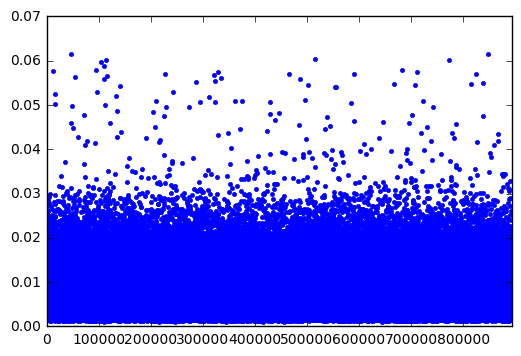

In [28]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

total['variance'].plot(style='.')

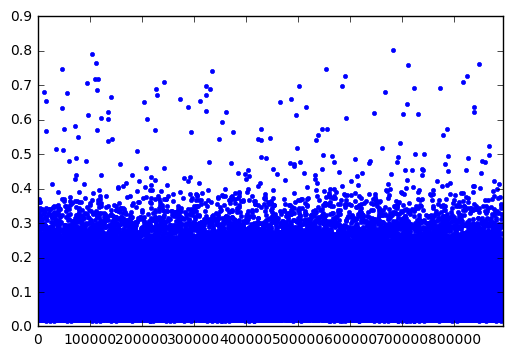

In [30]:
total['mean'].plot(style='.')